## POS tagging using modified Viterbi

<span style='color:orange;font-size:14px'>POS Tagging:</span><p style='font-size:13px'>is a process of assigning a word in a natural language sentence with a proper tag from a given set of tags.
* We will implement vanilla Viterbi algorithm using Penn Treebank training corpus with `universal` tagset
* We have 12 coarse classes | tags in our corpus</p>


### Data Preparation

In [54]:
#Importing libraries
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
import random
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import time
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [55]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [56]:
print(nltk_data[:2])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]


<span style='color:blue'>Splitting the Data into train & validation sets</span>

<p style='font-size:13px'>We use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, So that algorithm won't need a very high amount of runtime.</p>

In [57]:
#setting random.seed() to fetch same train & validation sets
random.seed(100)

#Splitting into train and validation sets
train_set,validate_set = train_test_split(nltk_data,test_size=0.05,random_state=42)

In [58]:
print("Train Set : length:",len(train_set),"\n",train_set[:1])

print("\nvalidate Set : length:",len(validate_set),"\n",validate_set[:1])

Train Set : length: 3718 
 [[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')]]

validate Set : length: 196 
 [[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'NOUN'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'NOUN'), ('Investment', 'NOUN'), ('Corp.', 'NOU

In [59]:
#Function for basic dataset info
def get_tagged_words_info(data):
    
    print("dataset length :",len(data))
    
    #Handle the case of the words in the corpus
    
    #fetch the (word,tag) from corpus
    word_tags = [(word_tag[0].lower(),word_tag[1]) for sent in data for word_tag in sent]
    #fetch words from (word,tag)
    words = [word_tag[0].lower() for word_tag in word_tags]
    #fetch tags from (word,tag)
    tags = [word_tag[1] for word_tag in word_tags]
    
    print("Total words: ",len(words),"\nVocabulory:",len(set(words)),"\nTotal Tags: ",len(set(tags)))
    
    #return the (word_tag) pairs, words,tags
    return word_tags,words,tags

In [60]:
#Train_set
print("Train Data Info:")
train_tagged_words,train_words,train_tags = get_tagged_words_info(train_set)

#Validate_set
print("\nvalidate Data Info:")
validate_tagged_words,validate_words,validate_tags = get_tagged_words_info(validate_set)

Train Data Info:
dataset length : 3718
Total words:  95589 
Vocabulory: 11102 
Total Tags:  12

validate Data Info:
dataset length : 196
Total words:  5087 
Vocabulory: 1798 
Total Tags:  12


In [61]:
print(train_tagged_words[:10])

[('bank', 'NOUN'), ('of', 'ADP'), ('new', 'NOUN'), ('england', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP')]


In [62]:
#Function for Emission Probability
def emission_probability(word,tag,df=train_tagged_words):
    
    #(word,tag) pairs with given 'tag'
    n_tags = [word_tag for word_tag in df if word_tag[1]==tag.upper()]
    #count of given `word` with the given `tag` 
    n_word_tag = len([word_tag[0] for word_tag in n_tags if word_tag[0]==word.lower()])
    
    return n_word_tag / len(n_tags)

In [63]:
#checking emission probability function for ('Bank','NOUN')
emission_probability('Bank','Noun')

0.0024067388688327317

In [64]:
#Function for transistion probability

def trans_probability(t1,t2,df=train_tagged_words):
    
    #Tag list 
    tags = [pair[1] for pair in df]
    #count of tags with given tag 't1'
    n_t1 = len([t for t in tags if t==t1.upper()])
    #intialise `t2 given t1` to 0
    n_t1_t2 = 0
    
    for index in range(len(tags)-1):
        #increament 'count of t2 given t1' if  t2 followed by t1  in tags of train Corpus
        if tags[index]==t1.upper() and tags[index+1]==t2.upper():
            n_t1_t2 += 1
            
    #return Transistion Probability
    return n_t1_t2/n_t1

In [65]:
#transistion probability of 'NOUN' followed by 'DET'
trans_probability('DET','NOUN')

0.6400289715113472

In [66]:
#Function to build the transistion matrix 

def transistion_matrix(df_tags = train_tagged_words):
    
    #Tag List
    tags = [pair[1] for pair in train_tagged_words]
    
    #unique Tag list
    T = list(set(tags))
    
    #intialise the tag matrix 
    T_matrix = np.zeros((len(T),len(T)),dtype='float32')
    
    #Fill up the transistion probabilities 
    for i,t1 in enumerate(T):
        for j,t2 in enumerate(T):
            T_matrix[i,j] = trans_probability(t1,t2)
    #DataFrame        
    df = pd.DataFrame(T_matrix,columns=T,index=T)
    return df

In [67]:
#Construct Transistion Matrix for the tags of train_set corpus 

Transistion_matrix = transistion_matrix(train_tags)

In [68]:
#print Transistion_matrix
Transistion_matrix

,ADJ,ADP,PRT,CONJ,NOUN,NUM,.,VERB,DET,PRON,ADV,X
ADJ,0.066645,0.078986,0.010861,0.016949,0.696725,0.020405,0.065328,0.012342,0.005101,0.000658,0.004608,0.021392
ADP,0.105297,0.017228,0.001498,0.000856,0.321776,0.062921,0.039486,0.008240,0.326378,0.069128,0.013162,0.034029
PRT,0.086303,0.021576,0.001635,0.002288,0.242563,0.058516,0.041517,0.402746,0.100360,0.018960,0.010134,0.013403
CONJ,0.116847,0.054435,0.004693,0.000469,0.349132,0.042234,0.034256,0.153918,0.121539,0.058658,0.055842,0.007977
NOUN,0.012289,0.176275,0.043832,0.041936,0.264632,0.009627,0.239179,0.147978,0.013310,0.004923,0.016884,0.029136
NUM,0.034196,0.034790,0.027951,0.013381,0.355338,0.184062,0.118347,0.017544,0.003271,0.001487,0.002974,0.206661
.,0.044972,0.091114,0.002339,0.057924,0.223152,0.080500,0.093812,0.088505,0.173502,0.065389,0.052078,0.026623
VERB,0.064649,0.090493,0.031121,0.005588,0.110904,0.022817,0.035312,0.169189,0.133101,0.036244,0.082577,0.218005
DET,0.204973,0.009054,0.000241,0.000483,0.640029,0.021970,0.017986,0.038387,0.005311,0.003742,0.012313,0.045509
PRON,0.074866,0.022918,0.012223,0.004966,0.211230,0.007257,0.041253,0.480901,0.009549,0.008021,0.033995,0.092819


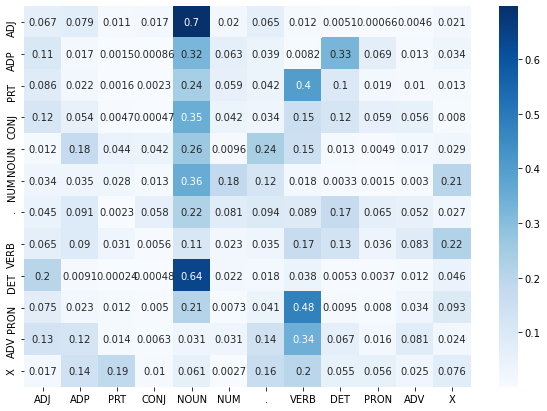

In [69]:
plt.figure(figsize=(10,7))
sns.heatmap(Transistion_matrix,annot=True,cmap='Blues')
plt.show()

<span style='color:brown'>Observation:</span>

- `Noun` followed by 'DET'|'ADJ' is most frequest tag pairs

### Build the vanilla Viterbi based POS tagger

<span style='color:orange;font-size:14px'>Viterbi Algorithm:</span><p style='font-size:13px'>- Dynamic programming approach to find the optimal tag sequence</p>

In [70]:
#Function for viterbi algorithm

def vanilla_viterbi(words,train = train_tagged_words):
    state = []
    Tags = list(set([pair[1] for pair in train]))
    
    for key,word in enumerate(words):
        
        p = []
        for tag in Tags:
            
            #transistion probability from transistion matrix, which we bult earlier
            
            if key == 0:
                #If it is first word, we will consider ['.',tag] for transistion probability
                #indicating it as start
                transistion_prob = Transistion_matrix.loc['.',tag]
            else:
                transistion_prob = Transistion_matrix.loc[state[-1],tag]
            #emission probability
            emission_prob = emission_probability(word,tag)
            
            #Calculating the state probability
            state_probability = emission_prob * transistion_prob
            
            #Appending to the probability list 'p'
            p.append(state_probability)
            
        #Pick max probability from the 'p' list
        p_max = max(p)
        
        #fetch the state|TAG with max state_probability
        state_max = Tags[p.index(p_max)]
        #append to the state list to track the previous one in coming iterations
        state.append(state_max)
    return list(zip(words,state))

In [71]:
#Function to calculate the accuracy
def calculate_accuracy(results,base):
    
    isMatch = [i for i,j in zip(results,base) if i==j]
    accuracy = round(len(isMatch)/len(results) * 100,2)
    
    print("Accuracy : ",accuracy,"%")
    
    return accuracy

In [72]:
#'accuracy' dictionary to hold different algorithms accuracies
accuracy = {}

<p style='font-size:14px;color:brown'>Run vanilla viterbi algorithm :</p>

In [73]:
#Running Viterbi algorithm on validate_set

#logging the time taken to run 
start = time.time()
#Viterbi Algorithm
resultant_tagged_seq = vanilla_viterbi(validate_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(resultant_tagged_seq[:10])

Time taken in seconds:  1707.7623805999756
[('for', 'ADP'), ('the', 'DET'), ('agency', 'NOUN'), ('for', 'ADP'), ('international', 'NOUN'), ('development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.')]


<p style='font-size:14px;color:brown'>Accuracy of vanilla viterbi:</p>

In [74]:
accuracy['vanilla_viterbi'] = calculate_accuracy(resultant_tagged_seq,validate_tagged_words)

Accuracy :  92.24 %


<p style='font-size:14px;color:brown'>Incorrect Tags</p>

In [75]:
#incorrect tags
incorrect_tags = [[validate_tagged_words[i-1],j] for i, j in enumerate(zip(resultant_tagged_seq, validate_tagged_words)) if j[0]!=j[1]]
incorrect_tags[:10]

[[('the', 'DET'), (('overseas', 'ADJ'), ('overseas', 'NOUN'))],
 [('overseas', 'NOUN'), (('private', 'ADJ'), ('private', 'NOUN'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('weekly', 'ADJ'), (('paycheck', 'ADJ'), ('paycheck', 'NOUN'))],
 [('paycheck', 'NOUN'), (('reasonably', 'ADJ'), ('reasonably', 'ADV'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('from', 'ADP'), (('tokio', 'ADJ'), ('tokio', 'NOUN'))],
 [('medical', 'ADJ'), (('protocols', 'ADJ'), ('protocols', 'NOUN'))]]

<span style='color:brown'>Observation:</span>
We can notice few words been inccorectly tagged like Overseas,pre-1917,paycheck,..

### Solve the problem of unknown words

Let's use `some lexical based and rule based techniques` to sort the unknown word problems by modifying our Vanilla_Viterbi algorithm

<span style='color:blue;font-size:16px'>Lexicon Based Techniques</span>

<span style='color:orange;font-size:13px'>Unigram Tagger:</span>
<p style='font-size:12px'>This tagger doesn't consider the word ordering</p>

In [76]:
#Unigram tagger
def unigram_tagger(train =train_set,validation =validate_set,checkword=False):
    
    unigram_tagger = nltk.UnigramTagger(train)

    #calculate the accuarcy
    unigram_accuracy = round(unigram_tagger.evaluate(validation),2)*100
    
    print("Unigram accuracy: ",unigram_accuracy,"%")
    accuracy['unigram_tagger'] = unigram_accuracy
    
    if checkword:
        return unigram_tagger.tag_sents([[(checkword)]])


In [77]:
#evaluating the unigram_tagger on validate_set
unigram_tagger(train_set,validate_set)

Unigram accuracy:  91.0 %


In [78]:
#Testing 'the' word tag
unigram_tagger(checkword='the')

Unigram accuracy:  91.0 %


[[('the', 'DET')]]

<span style='color:orange;font-size:13px'>Bigram Tagger:</span>

In [79]:
#Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set)

#calculate the accuracy
bigram_tagger_accuracy = round(bigram_tagger.evaluate(validate_set)*100,2)
accuracy['Bigram_tagger'] = bigram_tagger_accuracy 

print("The accuracy of the bigram Tagger is -", bigram_tagger_accuracy)

The accuracy of the bigram Tagger is - 21.68


<span style='color:orange;font-size:13px'>Trigram Tagger:</span>

In [80]:
#Trigram tagger with 'rule based tagger' as backoff 
def trigram_tagger(word,train_set = train_set):
    patterns = [
    (r'[aA-zZ]+(ing|ed|es)$', 'VERB'),              # words ending with 'ing|ed|es' considered as VERB
    (r'.*ould$', 'X'),              # modals
    (r'(The|the|A|a|An|an)$', 'DET'), #determiners
    (r'.*(\'s|s)$', 'NOUN'),   # possessive & plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^[0-9]+(st|nd|rd|th)+$','ADJ'), #RANKING as Adjective
    (r'.*', 'NOUN')                    # nouns
    ]
    #Rule based tagger with the above patterns
    rule_based_tagger = nltk.RegexpTagger(patterns)

    # trigram Tagger with regex tagger as back off
    trigram_rule_based_tagger = nltk.TrigramTagger(train_set, backoff=rule_based_tagger)
    
    return trigram_rule_based_tagger.tag_sents([[(word)]])

<span style='color:blue;font-size:16px'>Rule-Based Techniques</span>

<p style='font-size:13px'>Applies a set of handwritten rules and use contextual information to assign POS tags to words.

1. Let's define some rules to apply on our dataset
2. First, tag the words using `Lexicon based technique`
3. Then, apply the `rule_based tagger`

<span style='color:red'>Note:</span> Rule_Based Taggers always uses Lexicon based technique before applying the defined rules</p>

In [81]:
#defining rules for the rule based tagger
patterns = [
    (r'[aA-zZ]+(ing|ed|es)$', 'VERB'), # words ending with 'ing|ed|es' considered as VERB
    (r'.*ould$', 'X'),              # modals
    (r'(The|the|A|a|An|an)$', 'DET'), #determiners
    (r'.*(\'s|s)$', 'NOUN'),   # possessive & plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
    ]

In [82]:
#defining the rule based tagger with the above rules

rule_based_tagger = nltk.RegexpTagger(patterns)

#unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = round(rule_based_unigram_tagger.evaluate(validate_set)*100,2)
accuracy['Unigram_Rule_based_tagger'] = accuracy_rule_based_unigram_tagger

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 95.14


In [84]:
#Accuracies
accuracy

{'vanilla_viterbi': 92.24,
 'unigram_tagger': 91.0,
 'Bigram_tagger': 21.68,
 'Unigram_Rule_based_tagger': 95.14}

<span style='color:blue'>Modification 1:</span>
<span style='color:brown'>Viterbi Algorithm using trigram tagger:</span>

In [85]:
#Function for viterbi with Modification 1
def viterbi_Modification_1(words,train = train_tagged_words):
    state = []
    Tags = list(set([pair[1] for pair in train]))
    train_word_set = list(set([pair[0] for pair in train]))
    
    for key,word in enumerate(words):
        
        #if word is not in the train corpus
        if word not in train_word_set:
            #Use trigram tagger with rule based as backoff
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
            #state.append(tag[1] for word_tag in unknown_word_tag for tag in word_tag)
        else:
            p = []
            for tag in Tags:

                #transistion probability from transistion matrix, which we bult earlier
                if key == 0:
                    transistion_prob = Transistion_matrix.loc['.',tag]
                else:
                    transistion_prob = Transistion_matrix.loc[state[-1],tag]
                #emission probability
                emission_prob = emission_probability(word,tag)

                state_probability = emission_prob * transistion_prob
                p.append(state_probability)
            p_max = max(p)

            state_max = Tags[p.index(p_max)]
            state.append(state_max)
    return list(zip(words,state))

<span style='color:blue'>Modification 2:</span><span style='color:brown'>Viterbi Algorithm - considering "state_probabiblity = transistion probability" for unknown words
    :</span>

In [86]:
#Function for viterbi with Modification 2
def viterbi_Modification_2(words,train = train_tagged_words):
    state = []
    Tags = list(set([pair[1] for pair in train]))
    
    for key,word in enumerate(words):
        
        tag_state_prob = []
        tag_trans_prob = []
        for tag in Tags:

            #transistion probability from transistion matrix, which we bult earlier
            if key == 0:
                transistion_prob = Transistion_matrix.loc['.',tag]
            else:
                 transistion_prob = Transistion_matrix.loc[state[-1],tag]
            
            #emission probability
            emission_prob = emission_probability(word,tag)
            #state probability
            state_probability = emission_prob * transistion_prob
            
            tag_trans_prob.append(transistion_prob)
            tag_state_prob.append(state_probability)
            
        #pick max probability  
        p_max = max(tag_state_prob)
        
        #Incase,unknown word encountered - all the state probabilities become 0
        #In such case, STATE PROBABILITY = TRANSISTION PROBABILITY
        if p_max == 0:
            p_max = max(tag_trans_prob)
            tag_with_state_max = Tags[tag_trans_prob.index(p_max)]
        else:
            #tag with max state probability
            tag_with_state_max = Tags[tag_state_prob.index(p_max)]
        
        state.append(tag_with_state_max)
              
    return list(zip(words,state))

#### Evaluating tagging accuracy

<span style='color:blue'>Modification 1:</span>

<p style='font-size:13px'>
          - Used trigram tagger with rule based tagger as backoff for tagging the unknown words</p>

In [87]:
#Running Viterbi algorithm on validate_set

#logging the time taken to run 
start = time.time()
#Viterbi Algorithm
resultant_tagged_seq = viterbi_Modification_1(validate_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(resultant_tagged_seq[:10])

Time taken in seconds:  1909.5444457530975
[('for', 'ADP'), ('the', 'DET'), ('agency', 'NOUN'), ('for', 'ADP'), ('international', 'NOUN'), ('development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.')]


In [88]:
#calculate accuracy 

accuracy['viterbi_Modification_1'] = calculate_accuracy(resultant_tagged_seq,validate_tagged_words)

Accuracy :  94.89 %


<span style='color:brown'>Observation:</span>

 - On evaluating the viterbi algorithm with modification 1 on validation set, Accuracy has been improved to ~95%.
 - In Modification 1, for unknown words- we have condisered trigram tagger with rule based as backoff for setting the appropriate tags to them

<span style='color:blue'>Modification 2:</span>

<p style='font-size:13px'>
          - for unknown words: considered STATE_PROBABILITY = TRANSISTION_PROBABILTY</p>

In [89]:
#Running Viterbi algorithm on validate_set

#logging the time taken to run 
start = time.time()
#Viterbi Algorithm
resultant_tagged_seq = viterbi_Modification_2(validate_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(resultant_tagged_seq[:10])

Time taken in seconds:  1570.8961589336395
[('for', 'ADP'), ('the', 'DET'), ('agency', 'NOUN'), ('for', 'ADP'), ('international', 'NOUN'), ('development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.')]


In [90]:
#calculate accuracy
accuracy['viterbi_Modification_2'] = calculate_accuracy(resultant_tagged_seq,validate_tagged_words)

Accuracy :  93.49 %


<span style='color:brown'>Observation:</span>

 - On evaluating the viterbi algorithm with modification 2 on validation set, Accuracy has been improved slightly
 - In Modification 2: We have made state probabilities = transistion probabilities as the emission probabilities of unknown words becomes 0.

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [91]:
#accuracy of different tagger algorithms
accuracy

{'vanilla_viterbi': 92.24,
 'unigram_tagger': 91.0,
 'Bigram_tagger': 21.68,
 'Unigram_Rule_based_tagger': 95.14,
 'viterbi_Modification_1': 94.89,
 'viterbi_Modification_2': 93.49}

In [92]:
#Defining accuracy_df dataframe
accuracy_df = pd.DataFrame.from_dict(accuracy,orient='index',columns=['accuracy']).reset_index().rename(columns={'index':'Tagger_name'})

In [93]:
#accuracy_df dataframe
accuracy_df

,Tagger_name,accuracy
0,vanilla_viterbi,92.24
1,unigram_tagger,91.00
2,Bigram_tagger,21.68
3,Unigram_Rule_based_tagger,95.14
4,viterbi_Modification_1,94.89
5,viterbi_Modification_2,93.49


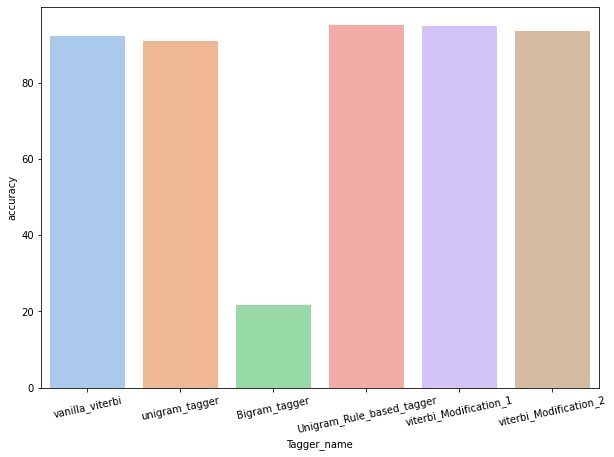

In [94]:
#plot showing the accuracies of different tagger algorithms
plt.figure(figsize=(10,7))
sns.barplot(data=accuracy_df,x='Tagger_name',y='accuracy',ci=None,palette="pastel")
plt.xticks(rotation=12)
plt.show()

<span style='color:orange'>Observation:</span>
    
   - From the accuracies, `Vanilla_ viterbi Modification_1` algorithm with trigram tagger has high accuracy rate with `95%` approx. as it handled the unknown word tags using trigram tagger with rule_based as backoff compared to `vanilla viterbi`
   - `Viterbi_Modification_2` also gave us better results when evaluated on validation set 
   - And also notice that unigram_Rule_based_tagger did pretty well, this is because the unigram tagger tags the unknown words with the high frequent tag and since this again backoff with some handwritten rules - it did a pretty good job

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

<span style='color:blue'>Using the test cases file provided 'Test_sentences.txt'</span>

In [95]:
#Reading "Test_sentences.txt" file 
test_cases = open("Test_sentences.txt",'r').read()

In [96]:
#Tokenise the sentences in the file
test = sent_tokenize(test_cases)

In [97]:
#test file
test

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta\nI would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experience t

In [98]:
#Function for calling viterbi,viterbi_Modification_1,viterbi_Modification_2 to tag the sentences
def corrector(sent):
    
    print("Sentence :\n",sent)
    tokens = word_tokenize(sent)
    print("\nwords: ",tokens)
    print("\nPOS Taggings:\n")
    print("vanilla_viterbi :",vanilla_viterbi(tokens))
    print("\nviterbi_modification_1 :",viterbi_Modification_1(tokens))
    print("\nviterbi_modification_2 :",viterbi_Modification_2(tokens))

<span style='color:blue'>Test Case 1:</span>

In [99]:
#Checking the test sentence
corrector("The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.")

Sentence :
 The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

words:  ['The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.']

POS Taggings:

vanilla_viterbi : [('The', 'DET'), ('2018', 'ADJ'), ('FIFA', 'ADJ'), ('World', 'NOUN'), ('Cup', 'ADJ'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'ADJ'), ('FIFA', 'ADJ'), ('World', 'NOUN'), ('Cup', 'ADJ'), (',', '.'), ('an', 'DET'), ('international', 'NOUN'), ('football', 'NOUN'), ('tournament', 'ADJ'), ('contested', 'ADJ'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]

viterbi_modification_1 : [('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'ADJ'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'

<span style='color:brown'>Observation:</span>

   - words like 'FIFA','2018','21st','cup', were not present in train corpus : So, `unmodified vanilla_viterbi tagged them incorrectly with a random tag`.
    
   - with `viterbi_modification_1` has corrected most of these where as `viterbi_modification_2` is not that accurate compared to modification_1

<span style='color:blue'>Test Case 2:</span>

In [100]:
corrector("Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.")

Sentence :
 Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

words:  ['Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.']

POS Taggings:

vanilla_viterbi : [('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.')]

viterbi_modification_1 : [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]

viterbi_modification_2 : [('Android', 'NOUN')

<span style='color:brown'>Observation:</span>

   - words like 'Android','OS','worldwide','smartphones' were not present in train corpus : So, `unmodified vanilla_viterbi tagged them incorrectly with a random tag`.
    
   - with `viterbi_modification_1 and viterbi_modification_2` : these words been identified correctly as `NOUN`

<span style='color:blue'>Test Case 3:</span>

In [101]:
#Tag the sentences
corrector("NASA invited social media users to experience the launch of ICESAT-2 Satellite.")

Sentence :
 NASA invited social media users to experience the launch of ICESAT-2 Satellite.

words:  ['NASA', 'invited', 'social', 'media', 'users', 'to', 'experience', 'the', 'launch', 'of', 'ICESAT-2', 'Satellite', '.']

POS Taggings:

vanilla_viterbi : [('NASA', 'ADJ'), ('invited', 'ADJ'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'ADJ'), ('Satellite', 'ADJ'), ('.', '.')]

viterbi_modification_1 : [('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]

viterbi_modification_2 : [('NASA', 'NOUN'), ('invited', 'NOUN'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'DET'), 

<span style='color:brown'>Observation:</span>

   - words like 'NASA','invited','ICESAT-2','satellite' were not present in train corpus : So, `unmodified vanilla_viterbi tagged them incorrectly with a random tag`.
    
   - with `viterbi_modification_1(with trigram tagger) : these words been identified correctly as `NOUN`

In [102]:
#Testing the entire test file provided

for sent in test:
    corrector(sent)

Sentence :
 Android is a mobile operating system developed by Google.

words:  ['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.']

POS Taggings:

vanilla_viterbi : [('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.')]

viterbi_modification_1 : [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]

viterbi_modification_2 : [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]
Sentence :
 Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

words:  ['Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 


viterbi_modification_1 : [('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('first', 'ADJ'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('to', 'PRT'), ('be', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Eastern', 'NOUN'), ('Europe', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('11th', 'ADJ'), ('time', 'NOUN'), ('that', 'ADP'), ('it', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Europe', 'NOUN'), ('.', '.')]

viterbi_modification_2 : [('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('first', 'ADJ'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('to', 'PRT'), ('be', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Eastern', 'NOUN'), ('Europe', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('11th', 'ADJ'), ('time', 'NOUN'), ('that', 'ADP'), ('it', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Europe', 'NOUN'), ('.', '.')]
Sentence :
 Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.

wo

<span style='color:brown'>Observation:</span>

- Many word tags been corrected by the modifications done to the vanilla viterbi algorithm